# GAN (Generative Adversarial Networks)


We simultaneously train two models: a generative model $G$ that captures the data distribution, and a discriminative model $D$ that estimates the probability that a sample came from the training data rather than $G$.

$D$ and $G$ play the following two-player minimax game with value function $V(G, D)$: 

$$
\min_G \max_D V(D, G) = \mathbb{E}_{\mathbf{x} \sim p_{\text{data}}(\mathbf{x})}[\log D(\mathbf{x})] + \mathbb{E}_{\mathbf{z} \sim p_{\mathbf{z}}(\mathbf{z})}[\log (1 - D(G(\mathbf{z})))].
$$

This translates into two minimization problems:

$$
\min_D -\mathbb{E}_{\mathbf{x} \sim p_{\text{data}}(\mathbf{x})}[\log D(\mathbf{x})] - \mathbb{E}_{\mathbf{z} \sim p_{\mathbf{z}}(\mathbf{z})}[\log (1 - D(G(\mathbf{z})))]
$$

$$
\min_G \mathbb{E}_{\mathbf{z} \sim p_{\mathbf{z}}(\mathbf{z})}[\log (1 - D(G(\mathbf{z})))]
$$

For $G$, we use the following loss instead:

$$
\min_G -\mathbb{E}_{\mathbf{z} \sim p_{\mathbf{z}}(\mathbf{z})}[\log (D(G(\mathbf{z})))]
$$

---
In summary,

$$
\min_D \mathbb{E}_{\mathbf{x} \sim p_{\text{data}}(\mathbf{x})}[-\log D(\mathbf{x})] + \mathbb{E}_{\mathbf{z} \sim p_{\mathbf{z}}(\mathbf{z})}[-\log (1 - D(G(\mathbf{z})))]
$$

$$
\min_G \mathbb{E}_{\mathbf{z} \sim p_{\mathbf{z}}(\mathbf{z})}[-\log (D(G(\mathbf{z})))]
$$

In practice,

$$
\min_D \text{BCELoss}(D(x), 1) + \text{BCELoss}(D(G(z)), 0)
$$

$$
\min_G \text{BCELoss}(D(G(z)), 1)
$$

because $\text{BCELoss}(x, y) = -(y\log x + (1-y)\log(1-x))$.

## DCGAN

In [ ]:
import time
import random
import argparse
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torchvision.transforms import v2


def weights_init(m):
    # custom weights initialization called on netG and netD
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


class Generator(nn.Module):
    def __init__(self, args):
        nz = args.nz
        ngf = args.ngf
        nc = args.nc
        super().__init__()
        self.main = nn.Sequential(
            # input is z, going into a convolution (bs, nz, 1, 1)
            nn.ConvTranspose2d(nz, ngf*8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            # state size. (bs, ngf*8, 4, 4)
            nn.ConvTranspose2d(ngf*8, ngf*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            # state size. (bs, ngf*4, 8, 8)
            nn.ConvTranspose2d(ngf*4, ngf*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            # state size. (bs, ngf*2, 16, 16)
            nn.ConvTranspose2d(ngf*2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (bs, ngf, 32, 32)
            nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # output. (bs, nc, 64, 64); [-1, 1]
        )

    def forward(self, x):
        return self.main(x)
    

class Discriminator(nn.Module):
    def __init__(self, args):
        nc = args.nc
        ndf = args.ndf
        super().__init__()
        self.main = nn.Sequential(
            # input is (bs, nc, 64, 64)
            nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (bs, ndf, 32, 32)
            nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (bs, ndf*2, 16, 16)
            nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (bs, ndf*4, 8, 8)
            nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (bs, ndf*8, 4, 4)
            nn.Conv2d(ndf*8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # output. (bs, 1, 1, 1); [0, 1]
        )

    def forward(self, x):
        return self.main(x)

In [ ]:
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--dataroot', type=str, default='data/',
                        help='Root directory for dataset')
    parser.add_argument('--workers', type=int, default=2,
                        help='Number of workers for dataloader')
    parser.add_argument('--batch_size', type=int, default=128,
                        help='Batch size during training')
    parser.add_argument('--image_size', type=int, default=64,
                        help='Spatial size of training images')
    parser.add_argument('--nc', type=int, default=1,
                        help='Number of channels in the training images')
    parser.add_argument('--nz', type=int, default=100,
                        help='Size of z latent vector (i.e. size of generator input)')
    parser.add_argument('--ngf', type=int, default=64,
                        help='Size of feature maps in generator')
    parser.add_argument('--ndf', type=int, default=64,
                        help='Size of feature maps in discriminator')
    parser.add_argument('--num_epochs', type=int, default=5,
                        help='Number of training epochs')
    parser.add_argument('--lr', type=float, default=0.0002,
                        help='Learning rate for optimizers')
    parser.add_argument('--beta1', type=float, default=0.5,
                        help='Beta1 hyperparam for Adam optimizers')
    parser.add_argument('--num_gpus', type=int, default=1,
                        help='Number of GPUs to use')
    args = parser.parse_args(args=[])
    return args

In [ ]:
def training_function(config, args):
    # Set random seed for reproducibility
    seed = 999
    random.seed(seed)
    torch.manual_seed(seed)

    dataset = datasets.MNIST(
        root=args.dataroot,
        download=True,
        transform=v2.Compose([
            v2.ToImage(),
            v2.Resize(args.image_size),               # Resize
            v2.ToDtype(torch.float32, scale=True),    # [0, 1]                    
            v2.Normalize((0.5,), (0.5,))              # [-1, 1]
        ])
    )

    # Create the dataloader
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=args.workers
    )

    # Decide which device we want to run on
    if torch.cuda.is_available() and args.num_gpus > 0:
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')

    output_dir = Path("outputs/torch", time.strftime("%Y%m%d-%H%M%S"))
    output_dir.mkdir(parents=True, exist_ok=True)

    # Plot some training images
    real_batch = next(iter(dataloader))
    torchvision.utils.save_image(
        real_batch[0][:64],
        output_dir / "sample-data.png",
        padding=2,
        normalize=True
    )

    # Create the discriminator
    discriminator = Discriminator(args).to(device)

    # Handle multi-gpu if desired
    if (device.type == 'cuda') and (args.num_gpus > 1):
        discriminator = nn.DataParallel(discriminator, list(range(args.num_gpus)))

    # Apply the weights_init function to randomly initialize all weights
    discriminator.apply(weights_init)

    # Create the generator
    generator = Generator(args).to(device)

    # Handle multi-gpu if desired
    if (device.type == 'cuda') and (args.num_gpus > 1):
        generator = nn.DataParallel(generator, list(range(args.num_gpus)))

    # Apply the weights_init function to randomly initialize all weights
    generator.apply(weights_init)

    # Initialize BCELoss function
    criterion = nn.BCELoss()

    # Create batch of latent vectors that we will use to visualize
    #  the progression of the generator
    fixed_noise = torch.randn(64, args.nz, 1, 1, device=device)

    # Establish convention for real and fake labels during training
    real_label = 1.0
    fake_label = 0.0

    # Set up Adam optimizers for both G and D
    optimizer_d = optim.Adam(discriminator.parameters(), lr=args.lr, betas=(args.beta1, 0.999))
    optimizer_g = optim.Adam(generator.parameters(), lr=args.lr, betas=(args.beta1, 0.999))

    # Lists to keep track of progress
    losses_g = []
    losses_d = []
    iteration = 0

    # Training Loop
    for epoch in range(args.num_epochs):
        for i, (data, _) in enumerate(dataloader):
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            # (a) Train with all-real batch
            discriminator.zero_grad()
            real = data.to(device)
            bs = real.size(0)
            label = torch.full((bs,), real_label, dtype=torch.float, device=device)
            # Foward pass real batch through D
            output = discriminator(real).view(-1)
            # Calculate D's loss on all-real batch
            loss_d_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            loss_d_real.backward()
            # D(x) -> want to be 1 for real images (D wants to classify real images as real)
            d_x = output.mean().item()

            # (b) Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(bs, args.nz, 1, 1, device=device)
            # Generate fake image batch with G
            fake = generator(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D (detach to avoid training G)
            output = discriminator(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            loss_d_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            loss_d_fake.backward()
            # D(G(z)) -> want to be 0 for fake images (D wants to classify fake images as fake)
            d_g_z1 = output.mean().item()
            # Compute loss of D as sum over the real and fake batches
            loss_d = loss_d_real + loss_d_fake
            # Update D
            optimizer_d.step()

            # (2) Update G network: maximize log(D(G(z)))
            generator.zero_grad()   # ensure that G's gradients are cleared
            label.fill_(real_label) # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = discriminator(fake).view(-1)
            # Calculate G's loss based on this output
            loss_g = criterion(output, label)
            # Calculate gradients for G
            loss_g.backward()
            # D(G(z)) -> want to be 1 for fake images (G wants to fool D so that D classifies fake images as real)
            d_g_z2 = output.mean().item()
            # Update G
            optimizer_g.step()

            # Output training stats
            if i % 50 == 0:
                print(
                    f"[{epoch}/{args.num_epochs}][{i}/{len(dataloader)}]\t"
                    f"Loss_D: {loss_d.item():.4f}\t"
                    f"Loss_G: {loss_g.item():.4f}\t"
                    f"D(x): {d_x:.4f}\t"
                    f"D(G(z)): {d_g_z1:.4f} / {d_g_z2:.4f}"                
                )
            
            # Save Losses for plotting later
            losses_d.append(loss_d.item())
            losses_g.append(loss_g.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iteration % 500 == 0) or ((epoch == args.num_epochs - 1) and (i == len(dataloader) - 1)):
                with torch.no_grad():
                    fake = generator(fixed_noise).detach().cpu()
                torchvision.utils.save_image(
                    fake,
                    output_dir / f"fake-{iteration:04d}.png",
                    padding=2,
                    normalize=True
                )

            # Increment iteration
            iteration += 1
    
    return output_dir, losses_g, losses_d

In [ ]:
args = parse_args()
print(args)
output_dir, losses_g, losses_d = training_function({}, args)

Namespace(dataroot='data/', workers=2, batch_size=128, image_size=64, nc=1, nz=100, ngf=64, ndf=64, num_epochs=5, lr=0.0002, beta1=0.5, num_gpus=1)
[0/5][0/469]	Loss_D: 1.4245	Loss_G: 2.7114	D(x): 0.4662	D(G(z)): 0.3464 / 0.0864
[0/5][50/469]	Loss_D: 0.0276	Loss_G: 9.9862	D(x): 0.9789	D(G(z)): 0.0001 / 0.0001
[0/5][100/469]	Loss_D: 0.3648	Loss_G: 11.9005	D(x): 0.7853	D(G(z)): 0.0005 / 0.0000
[0/5][150/469]	Loss_D: 0.1052	Loss_G: 4.4517	D(x): 0.9576	D(G(z)): 0.0523 / 0.0169
[0/5][200/469]	Loss_D: 3.5752	Loss_G: 14.6126	D(x): 0.9981	D(G(z)): 0.9444 / 0.0000
[0/5][250/469]	Loss_D: 0.4721	Loss_G: 6.6561	D(x): 0.9330	D(G(z)): 0.2899 / 0.0026
[0/5][300/469]	Loss_D: 0.7523	Loss_G: 4.4563	D(x): 0.5942	D(G(z)): 0.0437 / 0.0318
[0/5][350/469]	Loss_D: 0.3495	Loss_G: 1.9967	D(x): 0.7506	D(G(z)): 0.0149 / 0.1780
[0/5][400/469]	Loss_D: 0.2066	Loss_G: 2.9036	D(x): 0.8689	D(G(z)): 0.0493 / 0.0793
[0/5][450/469]	Loss_D: 0.2263	Loss_G: 2.9604	D(x): 0.8794	D(G(z)): 0.0775 / 0.0786
[1/5][0/469]	Loss_D: 0.

In [ ]:
import matplotlib.pyplot as plt

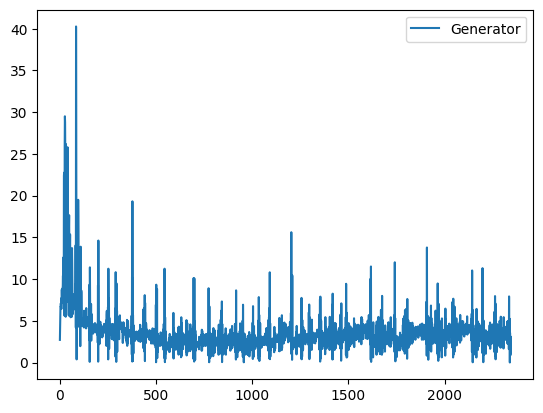

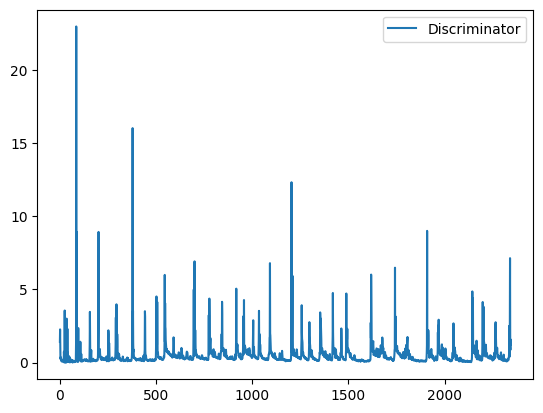

In [ ]:
plt.plot(losses_g, label='Generator')
plt.legend()
plt.show()

plt.plot(losses_d, label='Discriminator')
plt.legend()
plt.show()

In [ ]:
from PIL import Image

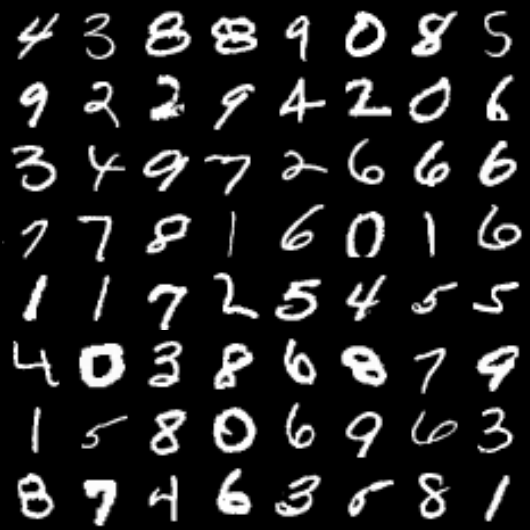

In [ ]:
Image.open(output_dir / "sample-data.png")

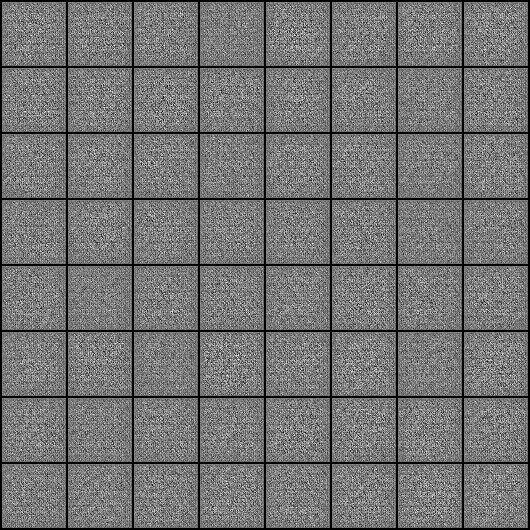

In [ ]:
Image.open(output_dir / "fake-0000.png")

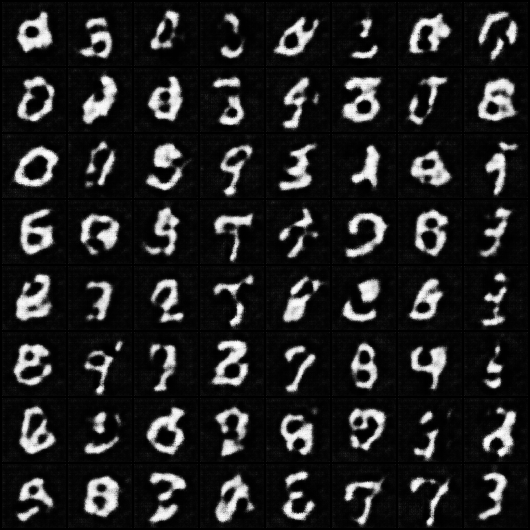

In [ ]:
Image.open(output_dir / "fake-0500.png")

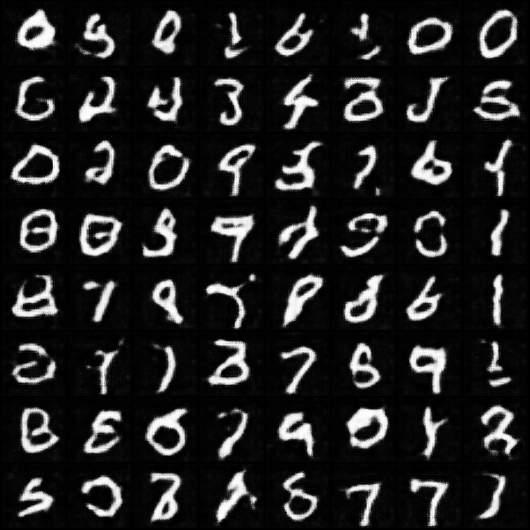

In [ ]:
Image.open(output_dir / "fake-1000.png")

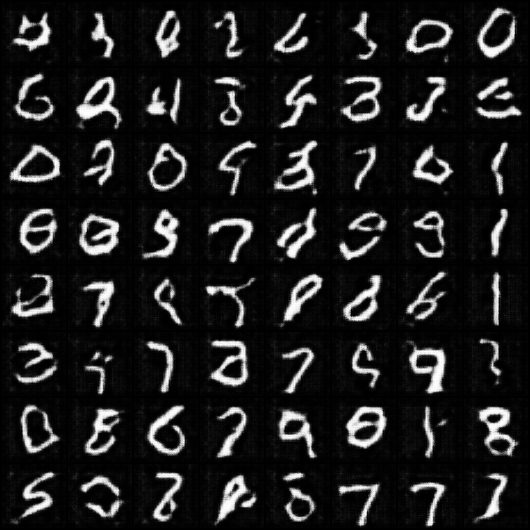

In [ ]:
Image.open(output_dir / "fake-1500.png")

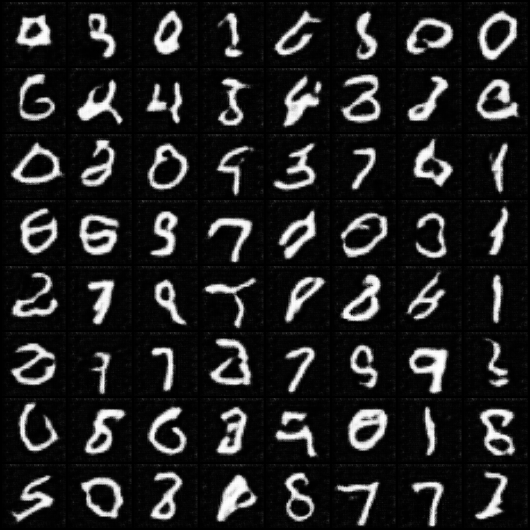

In [ ]:
Image.open(output_dir / "fake-2000.png")

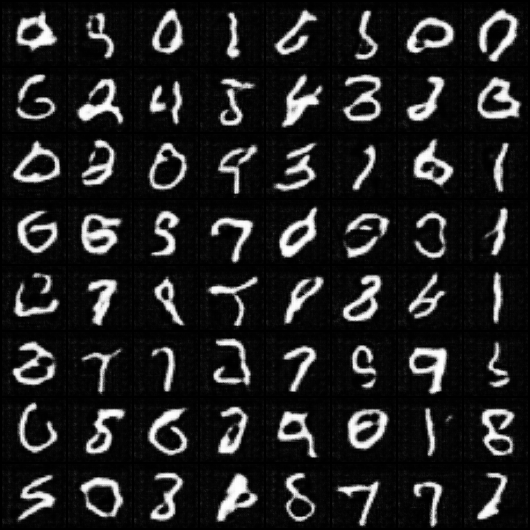

In [ ]:
Image.open(output_dir / "fake-2344.png")